### Hyperparameter tuning
used https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
import pandas as pd
mer_b0=pd.read_csv('mer_weather.csv')

In [2]:
dataset=mer_b0.drop(['site_id'], axis=1)

In [3]:
dataset=dataset.set_index('timestamp')

In [4]:
dataset.head()

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,
2016-01-01 00:00:00,28.10,15.6,-5.6,0.0,1015.3,270.0,3.6
2016-01-01 01:00:00,26.57,13.9,-5.6,0.0,1015.6,270.0,4.1
2016-01-01 02:00:00,25.73,13.3,-5.6,0.0,1016.0,270.0,3.1
2016-01-01 03:00:00,25.96,12.2,-6.1,0.0,1016.6,280.0,3.1
2016-01-01 04:00:00,25.59,11.7,-6.7,0.0,1017.0,270.0,3.1


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras import Sequential
import numpy as np
import math
from sklearn.metrics import mean_squared_error


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
    
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

def tuning(window_size,num_layer,batch_size,epoch):

    window_size=window_size

    # frame as supervised learning
    reframed = series_to_supervised(scaled, window_size, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)

    #split train and test
    values = reframed.values
    n_test_hours = 31*24
    train = values[:-n_test_hours, :]
    test = values[-n_test_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], window_size, int(train_X.shape[1]/window_size)))
    test_X = test_X.reshape((test_X.shape[0], window_size, int(test_X.shape[1]/window_size)))

    # design model
    model = Sequential()
    for i in range(num_layer-1):
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    #fit model
    history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch_size, 
                        validation_data=(test_X, test_y), verbose=0, shuffle=False)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], window_size*test_X.shape[2]))
    test_X[:,1:]

    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:7]), axis=1)
    inv_yhat
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:7]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    # return RMSE
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    return rmse
    

In [42]:
import numpy as np
np.random.randint(1,3)

2

In [ ]:
random_state = 42
num_loop = 30
hyperparameters_list = []

for loop in range(num_loop):
    window_size=np.random.choice(np.arange(24, 24*8, 24))
    num_layer=np.random.randint(1,4)
    batch_size=np.random.randint(32,129)
    epoch=np.random.randint(50,201)
    
    parameters = {'loop':loop,
                'window_size': window_size,
                'num_layer': num_layer,
                'batch_size': batch_size,
                'epoch': epoch}
    
    score = tuning(window_size,num_layer,batch_size,epoch)
    
    parameters['score'] = score
    
    print(f"{loop:2} iteration = {parameters['epoch']}, Score = {parameters['score']:.3f")
    
    hyperparameters_list.append(parameters)
    hyperparameters_data = pd.DataFrame(hyperparameters_list)
    hyperparameters_data = hyperparameters_data.sort_values(by="score")
    
    hyperparameters_data.to_csv("paramsearch.csv")
    
hyperparameters_data.head(10)

 0 best iteration = 79, Score = score
 1 best iteration = 147, Score = score


 2 best iteration = 91, Score = score
 3 best iteration = 102, Score = score
 4 best iteration = 67, Score = score


 5 best iteration = 97, Score = score
 6 best iteration = 129, Score = score
 7 best iteration = 184, Score = score


 8 best iteration = 157, Score = score
 9 best iteration = 114, Score = score
10 best iteration = 60, Score = score
11 best iteration = 161, Score = score


12 best iteration = 145, Score = score
13 best iteration = 136, Score = score
14 best iteration = 185, Score = score
15 best iteration = 99, Score = score
16 best iteration = 83, Score = score


17 best iteration = 121, Score = score
18 best iteration = 198, Score = score
19 best iteration = 187, Score = score
20 best iteration = 154, Score = score


21 best iteration = 195, Score = score
22 best iteration = 66, Score = score
23 best iteration = 112, Score = score


24 best iteration = 142, Score = score
25 best iteration = 171, Score = score
26 best iteration = 169, Score = score


27 best iteration = 122, Score = score
28 best iteration = 90, Score = score


### EDA

In [24]:
r=np.concatenate((yhat, test_X[:, 1:7]), axis=1)
r=scaler.inverse_transform(r)
r=pd.DataFrame(r)

In [25]:
len(r[0])

3935

In [26]:
def plot_series(time, series, format="-",start=0,end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("meter reading")
    plt.grid(True)

In [27]:
import matplotlib.pyplot as plt
series = np.array(graph_all)
time_step=[]
for x in range(len(series)):
    time_step.append(x)
time=np.array(time_step)
plot_series(time,series)

NameError: name 'graph_all' is not defined

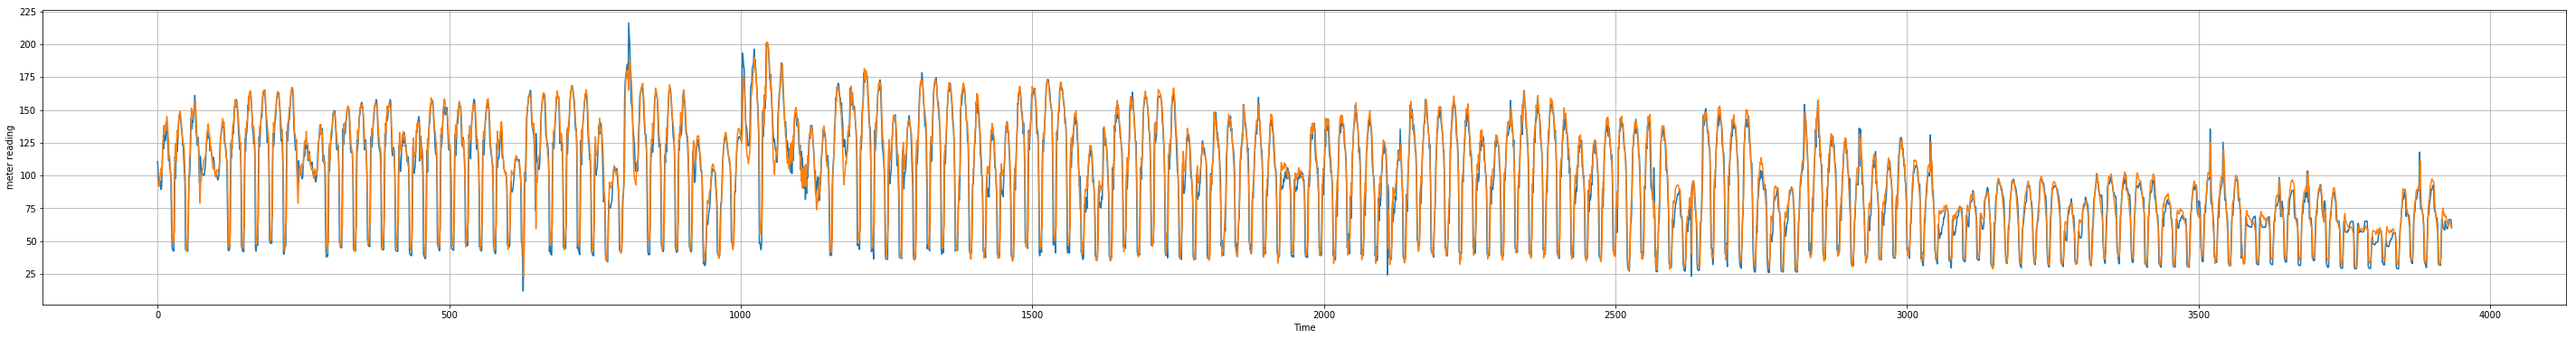

In [28]:
import matplotlib.pyplot as plt
series = inv_y
time_step=[]
for x in range(len(series)):
    time_step.append(x)
time=np.array(time_step)
plt.figure(figsize=(50, 6))
plot_series(time,series)
plot_series(time,r[0])